# Toxic Span Detection - LSTM with Attention
Project for Text Data Mining course at EITI-WUT

Authors: Julia Kłos, Patrycja Cieplicka

Date: 12.01.2020

### Import libraries

In [1]:
import pandas as pd

from src.SemEvalData import SemEvalData
from src.JigsawData import JigsawData
from nltk import tokenize
import nltk
import keras
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import Sequential
from keras import backend as K
from keras import optimizers
from keras.models import Model
from src.Attention import AttentionLayer as Attention
import re
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
from src.preprocessing import get_embeddings_index, get_embeddings_matrix,getSpansByToxicWords, clean_str
from test_sentence import vectorize, preprocess_lstm, test_attention, test_attention_2
import sklearn


Declaration of variables

In [20]:
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_WORD_NUM = 40    # maximum number of words in sentence
EMBED_SIZE = 300  ## same value as in dimension of word2vec
VAL_SPLIT = 0.001
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

Load wordnet

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load train data SemEval 2021 Toxic Span Detection

In [4]:
train_data_semeval = SemEvalData(MAX_WORD_NUM)
data = train_data_semeval.load_data("data/tsd_trial.csv")
train_df_preprocessed = train_data_semeval.preprocess()

### Preprocess data

Devide data into sentences

In [6]:
result = train_df_preprocessed
train_data = {
    'sentence':  result.sentences.sum(),
    'toxicity_sentence': result.toxicity_sentence.sum()
        }
print(train_data)

train_df = pd.DataFrame (train_data, columns = ['sentence','toxicity_sentence'])

{'sentence': ['because hes a moron and a bigot.', 'its not any more complicated than that.', 'how about we stop protecting idiots and let nature add some bleach to the gene pool.', 'we can always submit their names for the darwin awards.', 'if people  were  smart, they would  boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...', 'trump claimed that russia will never invade the ukraine, when russia already has - how stupid can people be?', 'as long as your willing to pay a lot more for products you buy, then fine.', 'but you better not be going to costco and walmart to buy stuff because its cheaper.', 'if so, we get to call you a hypocritical wanker.', 'only an idiot would use and believe anything this this republican propaganda machine publishes: www.realclearpolitics.com', 'thanks a lot douchebag.', 'youre the reason the portland buttfuckers are getting pushed out and moving down south

Tokenize words

In [7]:
sentences =[]
for i in train_df.sentence:
    sentences.append(nltk.word_tokenize(i))

Filter token that are not alphabetic

In [8]:
sentences_filter=[]
for i, w in enumerate(sentences):
    sentences[i] = [word for word in sentences[i] if word.isalpha()]

Delete empty sentences

In [ ]:
sentences = [x for x in sentences if x!=[]]

Word indexing

In [10]:
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, split=" ")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
word_counts = tokenizer.word_counts

Loading Word2Vec embedding model - pretrained on GoogleNews

In [11]:
import gensim
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True, limit = 1000000) 

Creating embedding matrix

In [12]:
EMBEDDING_DIM = 300
vocabulary_size=min(len(word_index)+1,MAX_FEATURES)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

In [13]:
absent_words =0
for word, i in word_index.items():
    if i>=MAX_FEATURES:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
        absent_words+=1

Creating input data coresponding with created embedding matrix

In [14]:
data_index = np.zeros((len(sentences), MAX_WORD_NUM), dtype='int32')
for i, sentence in enumerate(sentences):
    for k, word in enumerate(sentence):
        try:
            if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                data_index[i,k] = tokenizer.word_index[word]
        except:
            #print(word)
            pass

Split data into train and validation

In [21]:
print(data_index[:5])
indices = np.arange(data_index.shape[0])
np.random.shuffle(indices)
data = data_index[indices].copy()

labels = []
data = data.astype(np.float32)
labels = train_df.toxicity_sentence.iloc[indices]

nb_validation_samples = int(VAL_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = np.vstack(labels[:-nb_validation_samples])
x_val = data[-nb_validation_samples:]
y_val = np.vstack(labels[-nb_validation_samples:])

[[  67  118    4  150    2    4  877    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  54   18   65   55 1909   84    8    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  52   44   37  133  878   81    2  139  879 1202  101 1910    3    1
  1911 1203    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  37   45  129 1912   35 1204   13    1  880 1205    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  36   26   71  676   19   49 1206   12  561 1913   29   19   10   18
   676   34 1914 1915   39   12   66  134 1916  278    1   81   13    4
  1207    0    0    0    0  

### Build model

LSTM with Attention

In [17]:
model = Sequential()

model.add(Embedding(len(word_index)+1 ,EMBED_SIZE,weights=[embedding_matrix], input_length=MAX_WORD_NUM, trainable= True, name='embedding'))
# model.add(Input(shape=MAX_WORD_NUM, dtype='float32', name='input'))
model.add(Bidirectional(LSTM(40, return_sequences=True, kernel_regularizer=l2_reg), name='bidirectional'))

model.add(Dense(80, kernel_regularizer=l2_reg, name='dense'))
model.add(Dropout(0.2))
model.add(Attention(name='attention'))
model.add(Dense(1, activation='sigmoid', name='dense_final')) ##softmax, elu?

model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['acc']) ##adam
checkpoint = ModelCheckpoint('best_model_embeddings.h5', verbose=-2, monitor='val_loss',save_best_only=True, mode='auto')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           5542800   
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 80)            109120    
_________________________________________________________________
dense (Dense)                (None, 40, 80)            6480      
_________________________________________________________________
dropout (Dropout)            (None, 40, 80)            0         
_________________________________________________________________
attention (AttentionLayer)   (None, 80)                8200      
_________________________________________________________________
dense_final (Dense)          (None, 1)                 81        
Total params: 5,666,681
Trainable params: 5,666,681
Non-trainable params: 0
______________________________________________

### Train model

Epoch 1/30
85/85 [==============================] - 15s 175ms/step - loss: 0.4798 - acc: 0.7742 - val_loss: 0.4116 - val_acc: 0.8271
Epoch 2/30
85/85 [==============================] - 14s 170ms/step - loss: 0.3791 - acc: 0.8413 - val_loss: 0.4107 - val_acc: 0.8330
Epoch 3/30
85/85 [==============================] - 14s 162ms/step - loss: 0.3426 - acc: 0.8599 - val_loss: 0.4417 - val_acc: 0.8264
Epoch 4/30
85/85 [==============================] - 14s 164ms/step - loss: 0.3051 - acc: 0.8770 - val_loss: 0.4485 - val_acc: 0.8150
Epoch 5/30
85/85 [==============================] - 14s 164ms/step - loss: 0.2624 - acc: 0.8992 - val_loss: 0.5447 - val_acc: 0.7652
Epoch 6/30
85/85 [==============================] - 14s 165ms/step - loss: 0.2253 - acc: 0.9145 - val_loss: 0.5646 - val_acc: 0.7559
Epoch 7/30
85/85 [==============================] - 14s 164ms/step - loss: 0.1843 - acc: 0.9313 - val_loss: 0.6228 - val_acc: 0.7616
Epoch 8/30
85/85 [==============================] - 14s 169ms/step - 

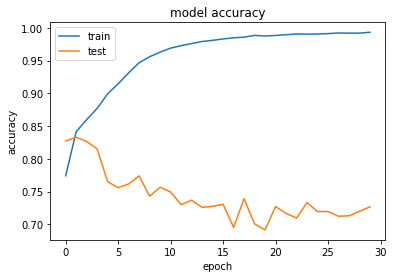

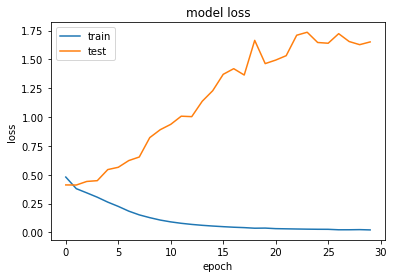

In [18]:
history = model.fit(x_train,  y_train, validation_data=(x_val, y_val), epochs=10, batch_size=216,shuffle=True, callbacks=[checkpoint])
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig('acc_att.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss_att.png')
plt.show()




In [32]:
model = keras.models.load_model('attention_model')
predictions = model.predict(x_train)
Y = np.where(predictions > 0.5,1,0)

print(sklearn.metrics.classification_report(y_train, Y))

model.save('attention_model')

predictions_val = model.predict(x_val)
Y_val = np.where(predictions_val > 0.5,1,0)

print(sklearn.metrics.classification_report(y_val, Y_val))


              precision    recall  f1-score   support

         0.0       0.59      0.63      0.61      1187
         1.0       0.39      0.35      0.37       804

    accuracy                           0.52      1991
   macro avg       0.49      0.49      0.49      1991
weighted avg       0.51      0.52      0.51      1991

INFO:tensorflow:Assets written to: attention_model\assets
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       1.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



### Evaluation

Load test data

In [3]:
test_data_semeval = SemEvalData()
data = test_data_semeval.load_data("data/tsd_train.csv")
test_df_preprocessed = test_data_semeval.preprocess()

Adapting explanation to sentences

In [5]:
test_df_preprocessed["predicted_span"]=[test_attention(sentences) for sentences in test_df_preprocessed["original_text"] ]

In [6]:
test_df_preprocessed

,spans,text,toxicity,toxic_words,original_text,sentences,diff,toxicity_sentence,predicted_span
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",another violent and aggressive immigrant killi...,1,[violent and aggressive immigrant],Another violent and aggressive immigrant killi...,[another violent and aggressive immigrant kill...,[],[1.0],"[8, 9, 10, 11, 12, 13, 14, 41, 42, 43, 44, 45,..."
1,"[33, 34, 35, 36, 37, 38, 39]","i am 56 years old, i am not your fucking junio...",1,[fucking],"I am 56 years old, I am not your fucking junio...","[i am 56 years old, i am not your fucking juni...","[94, 575, 588, 647]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[33, 34, 35, 36, 37, 38, 39, 141, 142, 143, 14..."
2,"[0, 1, 2, 3]","damn, a whole family. sad indeed.",1,[damn],"Damn, a whole family. Sad indeed.","[damn, a whole family., sad indeed.]",[],"[1.0, 0.0]","[0, 1, 2, 3]"
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",what a knucklehead. how can anyone not know th...,1,[knucklehead],What a knucklehead. How can anyone not know th...,"[what a knucklehead., how can anyone not know ...",[],"[1.0, 0.0, 0.0]","[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]"
4,"[32, 33, 34, 35, 36, 37, 38]",who do you think should do the killing? anyon...,1,[killing],"""who do you think should do the killing?""\n\nA...","[who do you think should do the killing?, anyo...","[0, 40, 442, 622, 933]","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[32, 33, 34, 35, 36, 37, 38, 32, 33, 34, 35, 3..."
...,...,...,...,...,...,...,...,...,...
1995,"[104, 105, 106, 107, 108, 109, 110, 111, 112, ...",i love these career politicians who think they...,1,[must secretly be a masochist],I love these career politicians who think they...,[i love these career politicians who think the...,[],"[0.0, 1.0]","[123, 124, 125, 126, 127, 128, 129, 130, 131]"
1996,"[21, 22, 23, 24, 25, 26, 27, 28, 29, 168, 169,...","what would jesus do? penniless as he was, and ...",1,"[penniless, pocrisy]","What would Jesus do? Penniless as he was, and ...","[what would jesus do?, penniless as he was, an...",[],"[0.0, 1.0, 1.0]","[166, 167, 168, 169, 170, 171, 172, 173, 174]"
1997,"[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]",hillary should face a firing squad . this is h...,1,[firing squad],Hillary should face a firing squad . This is h...,"[hillary should face a firing squad ., this is...",[],"[1.0, 0.0]","[22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33]"
1998,"[16, 17, 18, 19, 20, 21, 82, 83, 84, 85, 86, 8...",what a bunch of morons they are. tragic how ou...,1,"[morons, corrupt]",What a bunch of morons they are. Tragic how ou...,"[what a bunch of morons they are., tragic how ...",[],"[1.0, 1.0]","[16, 17, 18, 19, 20, 21]"


Calculate precission, recall and F for extracted words

In [7]:
test_df_preprocessed["Pscore"] = [ 1 if (len(s) == 0 and len(ps) == 0) 
                             else 0 if len(ps) == 0 
                             else len( set(s).intersection(set(ps) ))/ len(set(ps))  for s, ps in zip(test_df_preprocessed["spans"],test_df_preprocessed["predicted_span"]) ]

In [8]:
test_df_preprocessed["Rscore"] = [ 1 if (len(s) == 0 and len(ps) == 0) 
                             else 0 if len(s) == 0 
                             else len( set(s).intersection(set(ps) ))/ len(set(s))  for s, ps in zip(test_df_preprocessed["spans"],test_df_preprocessed["predicted_span"]) ]

In [9]:
test_df_preprocessed["Fscore"] = [ 0 if (p == 0 and r == 0)
    else 2 * p *r /(p + r) for p, r in zip(test_df_preprocessed["Pscore"], test_df_preprocessed["Rscore"] )]

In [10]:
F_score= np.mean(test_df_preprocessed["Fscore"])

In [11]:
F_score

0.631633729257583

In [12]:
P_score = np.mean(test_df_preprocessed["Pscore"])

In [13]:
P_score

0.7173522877935152

In [14]:
R_score = np.mean(test_df_preprocessed["Rscore"])

In [15]:
R_score

0.6587738040964524